In [3]:
import pandas as pd
import numpy as np
import requests
import random
from typing import List, Dict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
restaurants = [
    {"id":1,"name": "Kyoto Zen Vegan", "city": "Kyoto","tags":["vegan","japanese","budget"],"price":20},
    {"id":2,"name": "Tokyo Green Life","city":"Tokyo","tags":["vegan","fusion","midrange"],"price":35},
    {"id":3,"name": "Osaka Plant Eatery","city":"Osaka","tags":["vegan","ramen"],"price":15},
    {"id":4,"name": "Kyoto Tea Tranquility","city":"Kyoto","tags":["tea","culture"],"price":25},
]

hotels = [
    {"id":101,"name":"Tokyo Budget Inn","city":"Tokyo","stars":3,"price":60},
    {"id":102,"name":"Kyoto Cultural Hostel","city":"Kyoto","stars":3,"price":50},
    {"id":103,"name":"Mount Fuji Onsen Resort","city":"Hakone","stars":4,"price":180},
]

attractions = [
    {"id":201,"name":"Arashiyama Bamboo Forest","city":"Kyoto","tags":["nature","cultural"],"cost":0},
    {"id":202,"name":"Fushimi Inari Shrine","city":"Kyoto","tags":["cultural","outdoor"],"cost":5},
    {"id":203,"name":"Tokyo Anime District Tour","city":"Tokyo","tags":["popculture"],"cost":30},
    {"id":204,"name":"Traditional Tea Ceremony","city":"Kyoto","tags":["cultural","vegan"],"cost":25},
]

In [5]:
ratings_data = [
    {"user": "Alice", "item": 1, "rating": 5},
    {"user": "Alice", "item": 2, "rating": 4},
    {"user": "Alice", "item": 3, "rating": 2},

    {"user": "Bob", "item": 1, "rating": 4},
    {"user": "Bob", "item": 2, "rating": 5},
    {"user": "Bob", "item": 4, "rating": 3},

    {"user": "Clara", "item": 1, "rating": 4},
    {"user": "Clara", "item": 3, "rating": 5},
    {"user": "Clara", "item": 4, "rating": 2},
]
ratings_df = pd.DataFrame(ratings_data)
ratings_df.head()

,user,item,rating
0,Alice,1,5
1,Alice,2,4
2,Alice,3,2
3,Bob,1,4
4,Bob,2,5


In [6]:
class ContentBasedRecommender:
    def __init__(self, restaurants, hotels, attractions):
        self.restaurants = restaurants
        self.hotels = hotels
        self.attractions = attractions
    
    def recommend_restaurants(self, dietary_pref="vegan", max_price=40):
        return [r for r in self.restaurants if dietary_pref in r["tags"] and r["price"]<=max_price]
    
    def recommend_hotels(self, budget=80):
        return [h for h in self.hotels if h["price"] <= budget]
    
    def recommend_attractions(self, interest="cultural"):
        return [a for a in self.attractions if interest in a["tags"]]

In [7]:
class CollaborativeRecommender:
    def __init__(self, ratings_df, items):
        self.ratings = ratings_df
        self.items = {item["id"]: item for item in items}
        self.utility_matrix = ratings_df.pivot(index="user", columns="item", values="rating").fillna(0)
        self.similarity = cosine_similarity(self.utility_matrix)
        self.sim_df = pd.DataFrame(self.similarity, index=self.utility_matrix.index, columns=self.utility_matrix.index)
    
    def recommend(self, user):
        scores = self.sim_df[user].drop(user)
        similar_user = scores.idxmax()  # pick most similar
        top_items = self.utility_matrix.loc[similar_user].sort_values(ascending=False)
        recommended = top_items[top_items>3].index.tolist()  # items rated highly
        return [self.items[i] for i in recommended]


In [8]:
class HybridRecommender:
    def __init__(self, cb_recommender, collab_recommender):
        self.cb = cb_recommender
        self.collab = collab_recommender
    
    def recommend_restaurants(self, user, dietary="vegan", max_price=40):
        cb_list = self.cb.recommend_restaurants(dietary, max_price)
        collab_list = self.collab.recommend(user)
        ids = {r["id"]: r for r in cb_list}
        for r in collab_list:
            if r["id"] in ids:
                ids[r["id"]]["hybrid_boost"] = True
        return list(ids.values())

### Execute below commands
### ollama pull phi3:mini
### ollama run phi3:mini

In [15]:
import requests, json

class TravelAgent:
    def __init__(self, hybrid_recommender, ollama_base="http://localhost:11434"):
        self.recommender = hybrid_recommender
        self.ollama_base = ollama_base
    
    def plan_trip(self, user="Alice", days=5, budget=2000, dietary="vegan", interest="cultural"):
        # Hotels: divide budget over days
        hotels = self.recommender.cb.recommend_hotels(budget // days)
        
        # Restaurants: hybrid (content + collaborative)
        restaurants = self.recommender.recommend_restaurants(user, dietary)
        
        # Attractions: content filter
        attractions = self.recommender.cb.recommend_attractions(interest)
        
        return {
            "days": days,
            "hotels": hotels,
            "restaurants": restaurants,
            "attractions": attractions
        }

    def narrate_itinerary(self, trip):
        prompt = (
            f"Generate a cheerful, day-by-day travel itinerary in Japan. "
            f"Hotels: {trip['hotels']}, "
            f"Restaurants: {trip['restaurants']}, "
            f"Attractions: {trip['attractions']}."
        )

        try:
            with requests.post(
                f"{self.ollama_base}/api/generate",
                json={"model": "phi3:mini", "prompt": prompt},
                stream=True
            ) as resp:
                narrative = ""
                for line in resp.iter_lines():
                    if line:
                        data = json.loads(line.decode("utf-8"))
                        if "response" in data:
                            narrative += data["response"]
                        if data.get("done", False):
                            break
                return narrative.strip()
        except Exception as e:
            return f"(Fallback: could not connect to Ollama — {e})"

In [16]:
def draw_flow():
    G = nx.DiGraph()
    edges = [
        ("User","Agent"),
        ("Agent","Content-Based Recommender"),
        ("Agent","Collaborative Recommender"),
        ("Content-Based Recommender","Hybrid Recommender"),
        ("Collaborative Recommender","Hybrid Recommender"),
        ("Hybrid Recommender","Agent"),
        ("Agent","Ollama LLM"),
        ("Ollama LLM","Final Itinerary"),
    ]
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G, seed=42)
    
    # Automatically assign colors based on number of nodes
    palette = plt.cm.Set3(np.linspace(0,1,len(G.nodes())))
    
    plt.figure(figsize=(10,6))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=palette,
        node_size=2500,
        arrowsize=20,
        font_size=9
    )
    plt.title("GlobeGenie Flow: From User → Agent → Recommenders → Ollama → Final Plan",
              fontsize=12, color="darkred")
    plt.show()

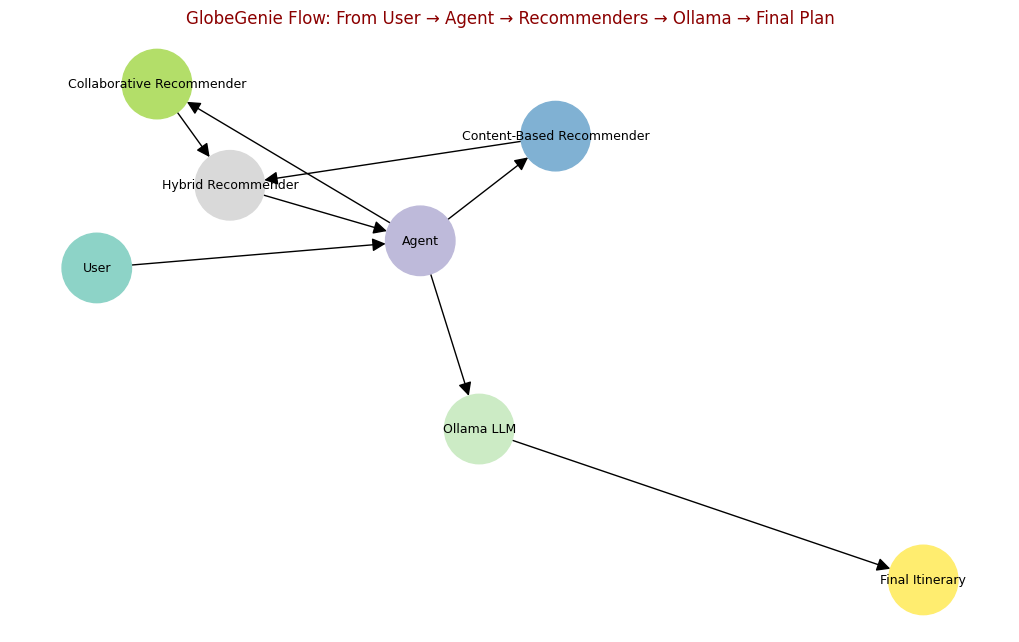

In [17]:
draw_flow()

In [18]:
cb = ContentBasedRecommender(restaurants,hotels,attractions)
collab = CollaborativeRecommender(ratings_df,restaurants)
hybrid = HybridRecommender(cb,collab)
agent = TravelAgent(hybrid)

trip = agent.plan_trip(user="Alice", days=5, budget=2000, dietary="vegan", interest="cultural")
print("=== RAW PLAN ===")
print(trip)

print("\n=== NARRATED ITINERARY ===")
print(agent.narrate_itinerary(trip))

=== RAW PLAN ===
{'days': 5, 'hotels': [{'id': 101, 'name': 'Tokyo Budget Inn', 'city': 'Tokyo', 'stars': 3, 'price': 60}, {'id': 102, 'name': 'Kyoto Cultural Hostel', 'city': 'Kyoto', 'stars': 3, 'price': 50}, {'id': 103, 'name': 'Mount Fuji Onsen Resort', 'city': 'Hakone', 'stars': 4, 'price': 180}], 'restaurants': [{'id': 1, 'name': 'Kyoto Zen Vegan', 'city': 'Kyoto', 'tags': ['vegan', 'japanese', 'budget'], 'price': 20, 'hybrid_boost': True}, {'id': 2, 'name': 'Tokyo Green Life', 'city': 'Tokyo', 'tags': ['vegan', 'fusion', 'midrange'], 'price': 35, 'hybrid_boost': True}, {'id': 3, 'name': 'Osaka Plant Eatery', 'city': 'Osaka', 'tags': ['vegan', 'ramen'], 'price': 15}], 'attractions': [{'id': 201, 'name': 'Arashiyama Bamboo Forest', 'city': 'Kyoto', 'tags': ['nature', 'cultural'], 'cost': 0}, {'id': 202, 'name': 'Fushimi Inari Shrine', 'city': 'Kyoto', 'tags': ['cultural', 'outdoor'], 'cost': 5}, {'id': 204, 'name': 'Traditional Tea Ceremony', 'city': 'Kyoto', 'tags': ['cultural', 

KeyboardInterrupt: 